In [48]:
import gpxpy
import pandas as pd
import numpy as np
import geopy.distance

def convert_gpx(path):
    with open(path, 'r') as f:
        gpx = gpxpy.parse(f)
        data = gpx.tracks[0].segments[0].points



    df = pd.DataFrame(columns=['lat', 'lon', 'ele', 'time', 'power', 'hr', 'cad', 'temperature'
                           # don't add empty columns                           ,'distance','alt_difference', 'duration'
                           ])
    for point in data:
        power = None
        hr = None
        cadence = None
        temp = None
        # Safely access extensions
        for ext in point.extensions:
            if ext.tag.endswith('power'):
                power = int(ext.text)
            if ext is not None:
                for child in ext:
                    if (child.tag.endswith('hr')):
                        hr = int(child.text)
                    if (child.tag.endswith('cad')):
                        cadence = int(child.text)
                    if (child.tag.endswith('atemp')):
                        temp = float(child.text)
        new_row = pd.DataFrame({'lat': [point.latitude],
                                'lon': [point.longitude],
                                'ele': [point.elevation],
                                'time': [point.time],
                                'power': [power]
                                   , 'hr': [hr],
                                'cad': [cadence]
                                   , 'temperature': [temp]
                                })
        df = pd.concat([df, new_row], ignore_index=True)

    df['hr'] = df['hr'].astype(int)
    df['cad'] = df['cad'].astype(int)
    df['power'] = df['power'].astype(float)
    df['temperature'] = df['temperature'].astype(float)
    df['distance'] = pd.Series(dtype='float')
    df['alt_difference'] = pd.Series(dtype='float')
    df['duration'] = pd.Series(dtype='float')
    df['velocity'] = pd.Series(dtype='float')

    for i in range(1, len(df)):
        coords_1 = (df.loc[i-1, 'lat'],df.loc[i-1, 'lon'])
        coords_2 = (df.loc[i, 'lat'],df.loc[i, 'lon'])
        distance = geopy.distance.geodesic(coords_1, coords_2).m
        elevation =  df.loc[i, 'ele'] - df.loc[i-1, 'ele']
        duration = (df.loc[i, 'time'] - df.loc[i-1, 'time']).total_seconds()
        # filter out odd gps coords
        if distance > 30 or distance == 0:
            distance = None
            elevation = None
            duration = None
        if distance is not None and elevation is not None:
            velocity = 3.6 * np.sqrt(distance**2 + elevation**2)
        else:
            velocity = None
        df.loc[i, 'distance'] = distance
        df.loc[i, 'alt_difference'] = elevation
        df.loc[i, 'velocity'] = velocity
        df.loc[i, 'duration'] = duration

    df['gradient'] = df['alt_difference'].mul(100).div(df['distance'].replace(0, np.nan))
    df['time'] = df['time'].dt.tz_localize(None)
    df = df.set_index('time')
    return df

paths = ['Strava/L_Etape_2022.gpx', 'Strava/L_Etape_2023.gpx', 'Strava/L_Etape_2024.gpx']

dfs = []

for path in paths:
    df = convert_gpx(path)
    dfs.append(df)

def convert_df(df):
    strava = df[['power'
        ,'hr'
        ,'cad'
        ,'temperature'
        ,'distance'
        ,'gradient'
        ,'velocity'
                 ]].dropna()


    strava = strava.drop(strava[strava.cad < 30].index)
    return strava

stravas = []

for df in dfs:
    strava = convert_df(df)
    stravas.append(strava)

C:\Users\lilyh\AppData\Local\Temp\ipykernel_28884\404985681.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)
C:\Users\lilyh\AppData\Local\Temp\ipykernel_28884\404985681.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)
C:\Users\lilyh\AppData\Local\Temp\ipykernel_28884\404985681.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a futur

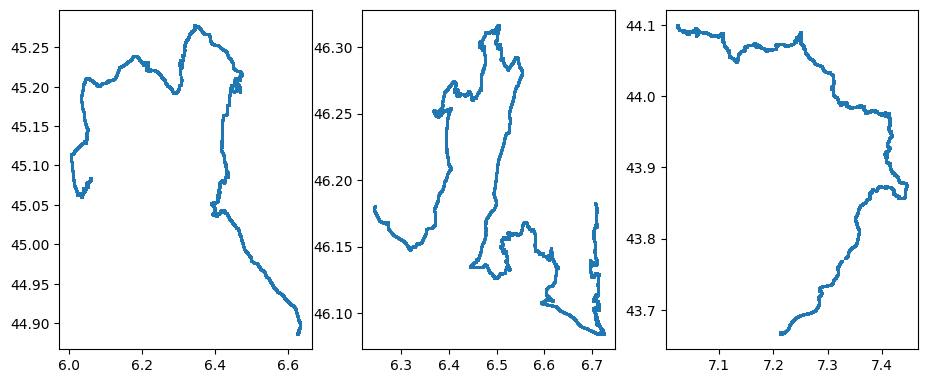

In [49]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5*len(dfs), 5*len(dfs)))
for i in range(len(dfs)):
    df = dfs[i]
    ax = fig.add_subplot(3,len(dfs)+1, i+1)
    ax.plot(df.lon, df.lat, 'o', markersize=1)

## Heartrate and Cadence

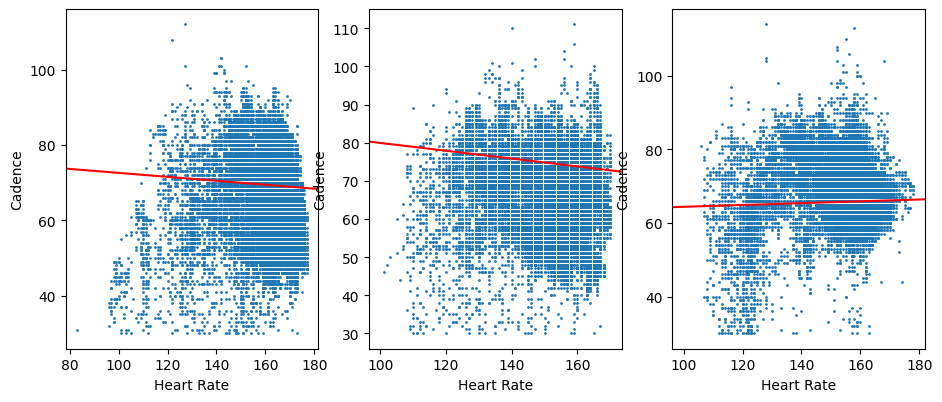

In [69]:
fig = plt.figure(figsize=(5*len(dfs), 5*len(dfs)))
for i in range(len(stravas)):
    strava = stravas[i]
    ax = fig.add_subplot(3,len(dfs)+1, i+1)
    ax.scatter(strava.hr, strava.cad, s =1)
    plt.xlabel("Heart Rate")
    plt.ylabel("Cadence")
    m, b = np.polyfit(strava.hr, strava.cad, deg=1)
    plt.axline(xy1=(100, b), slope=m, color='r', label=f'$y = {m:.2f}x {b:+.2f}$')

## Cadence and Power

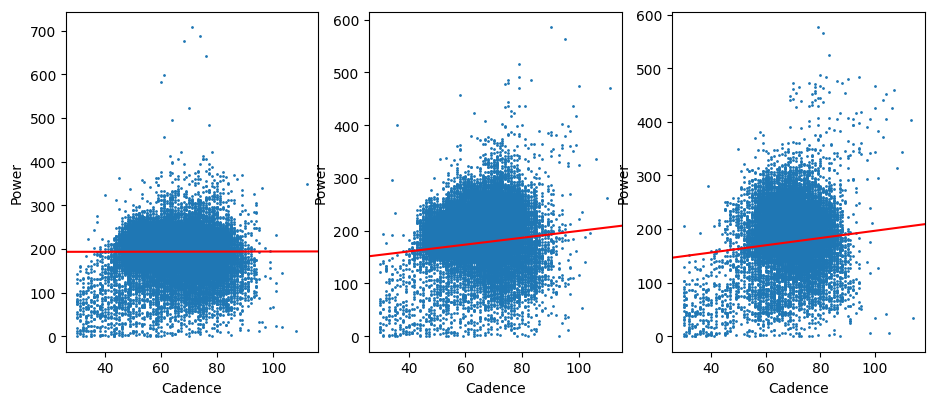

In [66]:
fig = plt.figure(figsize=(5*len(dfs), 5*len(dfs)))
for i in range(len(stravas)):
    strava = stravas[i]
    ax = fig.add_subplot(3,len(dfs)+1, i+1)
    ax.scatter(strava.cad, strava.power,  s =1)
    plt.xlabel("Cadence")
    plt.ylabel("Power")
    m, b = np.polyfit(strava.cad, strava.power, deg=1)
    plt.axline(xy1=(30, b), slope=m, color='r', label=f'$y = {m:.2f}x {b:+.2f}$')

## Heartrate and Power

-61.640763705707165
-67.88086062562851
-101.9377219996455


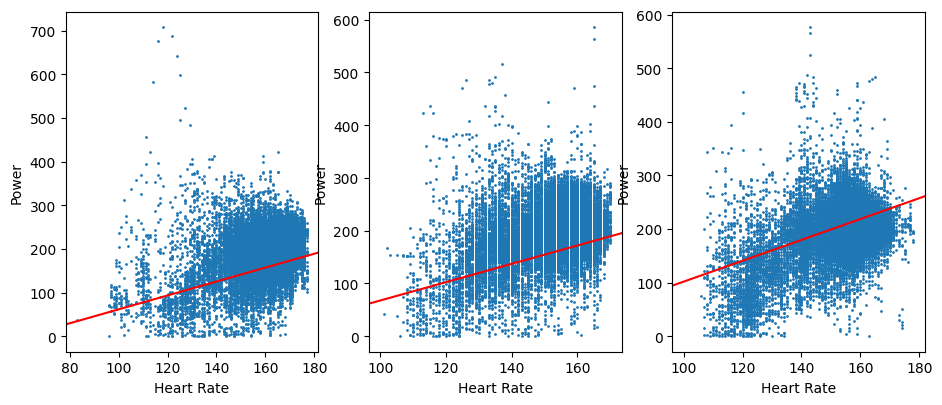

In [67]:
fig = plt.figure(figsize=(5*len(dfs), 5*len(dfs)))
for i in range(len(stravas)):
    strava = stravas[i]
    ax = fig.add_subplot(3,len(dfs)+1, i+1)
    ax.scatter(strava.hr, strava.power, s =1)
    plt.xlabel("Heart Rate")
    plt.ylabel("Power")
    m, b = np.polyfit(strava.hr, strava.power, deg=1)

    plt.axline(xy1=(100, b * -1), slope=m, color='r', label=f'$y = {m:.2f}x {b:+.2f}$')